<a href="https://colab.research.google.com/github/vincm1/UK_accidents/blob/main/Final_assignment_Big_Data_for_Decision_Making_(2021_22_BNK432_NO02_A).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Final assignment - Big Data for Decision Making (2021-22 BNK432_NO02_A)

In [274]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
var command = "NOTEBOOK_FULL_PATH = '" + nb.notebook_path + "'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [275]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings("ignore")

In [276]:
df = pd.read_csv("UK Road Accidents 2018.csv")
df.head()

,datetime,Count,Day_of_Week,Precipitation,High_Winds,Road_Surface_Conditions,Light_Conditions,Urban_or_Rural_Area
0,2018-01-01 00:00:00,18,Monday,Fine,False,Dry,Darkness - lights lit,Urban
1,2018-01-01 01:00:00,9,Monday,Fine,False,Wet or damp,Darkness - lights lit,Urban
2,2018-01-01 02:00:00,14,Monday,Fine,False,Wet or damp,Darkness - lights lit,Urban
3,2018-01-01 03:00:00,10,Monday,Fine,False,Wet or damp,Darkness - lights lit,Urban
4,2018-01-01 04:00:00,8,Monday,Fine,False,Dry,Darkness - lights lit,Urban


## 1) **Business** **objective**

The above seen data set is published by the UK Department for Transport and is published sinced 1978. For this report, a snippet of the data is taken and handles all road accidents that happened in 2018 on an hourly level. The data contains information about the hour as well as the count of how many accidents happened on UK's streets. Furthermore, it shows which day of the week it has been, the condition of precipitation within that time as well as whether there was high wind. Moreover, the dataset contains information about the road surface conditions, light conditions and in what kind of area the accidents in that hour happened.

The goal of this report is to forecast the number of hourly accidents occuring on UK streets for Britannia Rescue in order to help its rescourcing planning by an appropriate model.

To predict the numbers the following report structure will be included. First, the data will explored and preprocessed. Secondly, the features are selected and a baseline model will be drawn. Thirdly, models will be trained, hyperparameters tuned and thereby evaluated, which model shows the best performance for predicting road accidents for the client. To sum up, the results will be discussed and further steps will be introduced.

### Data inspection 

In [145]:
df.columns

Index(['datetime', 'Count', 'Day_of_Week', 'Precipitation', 'High_Winds',
       'Road_Surface_Conditions', 'Light_Conditions', 'Urban_or_Rural_Area'],
      dtype='object')

In [146]:
df.shape

(8540, 8)

In [147]:
df.describe()

,Count
count,8540.000000
mean,14.358548
std,10.479488
min,1.000000
25%,5.000000
50%,13.000000
75%,21.000000
max,62.000000


In [148]:
df.dtypes

datetime                   object
Count                       int64
Day_of_Week                object
Precipitation              object
High_Winds                   bool
Road_Surface_Conditions    object
Light_Conditions           object
Urban_or_Rural_Area        object
dtype: object

Creating more granularity in the date info

In [149]:
df["datetime"] = pd.to_datetime(df["datetime"])

In [150]:
df["day"] = df["datetime"].dt.date
df["day"] = pd.to_datetime(df["day"])

In [151]:
df["day_n"] = df["datetime"].dt.day

In [152]:
df["hour"] = df["datetime"].dt.hour

In [153]:
df["month"] = df["datetime"].dt.month_name()

In [154]:
df["month_n"] = df["datetime"].dt.month

In [155]:
df.loc[(df['Day_of_Week'] == 'Saturday') | (df['Day_of_Week'] == 'Sunday'), 'Weekend'] = 'Weekend'
df.loc[(df['Day_of_Week'] != 'Saturday') & (df['Day_of_Week'] != 'Sunday'), 'Weekend'] = 'Weekday'  

In [156]:
conditions_season = [
                     ((df["month"] == "December") | (df["month"] == "January") | (df["month"] == "February")),
                     ((df["month"] == "March") | (df["month"] == "April") | (df["month"] == "May")),
                     ((df["month"] == "June") | (df["month"] == "July") | (df["month"] == "August")),
                     (df["month"] == "September") | (df["month"] == "October") | (df["month"] == "November")
]

values_season = ["Winter","Spring","Summer","Autumn"]

df["Season"] = np.select(conditions_season, values_season)

In [157]:
df[6000:]

,datetime,Count,Day_of_Week,Precipitation,High_Winds,Road_Surface_Conditions,Light_Conditions,Urban_or_Rural_Area,day,day_n,hour,month,month_n,Weekend,Season
6000,2018-09-15 01:00:00,8,Saturday,Fine,False,Dry,Darkness - lights lit,Urban,2018-09-15,15,1,September,9,Weekend,Autumn
6001,2018-09-15 02:00:00,4,Saturday,Fine,False,Dry,Darkness - lights lit,Urban,2018-09-15,15,2,September,9,Weekend,Autumn
6002,2018-09-15 03:00:00,3,Saturday,Fine,False,Dry,Darkness - lights lit,Urban,2018-09-15,15,3,September,9,Weekend,Autumn
6003,2018-09-15 04:00:00,5,Saturday,Fine,False,Dry,Darkness - lights lit,Urban,2018-09-15,15,4,September,9,Weekend,Autumn
6004,2018-09-15 05:00:00,4,Saturday,Fine,False,Dry,Darkness - lighting unknown,Rural,2018-09-15,15,5,September,9,Weekend,Autumn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8535,2018-12-31 19:00:00,13,Monday,Fine,False,Dry,Darkness - lights lit,Urban,2018-12-31,31,19,December,12,Weekday,Winter
8536,2018-12-31 20:00:00,12,Monday,Fine,False,Dry,Darkness - lights lit,Urban,2018-12-31,31,20,December,12,Weekday,Winter
8537,2018-12-31 21:00:00,5,Monday,Fine,False,Dry,Darkness - lights lit,Urban,2018-12-31,31,21,December,12,Weekday,Winter
8538,2018-12-31 22:00:00,18,Monday,Fine,False,Dry,Darkness - lights lit,Urban,2018-12-31,31,22,December,12,Weekday,Winter


In [158]:
cat_names = ['Day_of_Week', 'Weekend','Precipitation', 'High_Winds',
       'Road_Surface_Conditions', 'Light_Conditions', 'Urban_or_Rural_Area', 'month','Weekend','Season','hour']
print("Unique count of categorical features:")
for i in cat_names:
  print(i,df[i].unique().size)

Unique count of categorical features:
Day_of_Week 7
Weekend 2
Precipitation 7
High_Winds 2
Road_Surface_Conditions 6
Light_Conditions 5
Urban_or_Rural_Area 2
month 12
Weekend 2
Season 4
hour 24


In [159]:
for i in cat_names:
  print(i,df[i].unique())

Day_of_Week ['Monday' 'Tuesday' 'Wednesday' 'Thursday' 'Friday' 'Saturday' 'Sunday']
Weekend ['Weekday' 'Weekend']
Precipitation ['Fine' 'Other' 'Raining' 'Fog or mist' 'Unknown' 'Snowing'
 'Data missing or out of range']
High_Winds [False  True]
Road_Surface_Conditions ['Dry' 'Wet or damp' 'Frost or ice' 'Snow' 'Flood over 3cm. deep'
 'Data missing or out of range']
Light_Conditions ['Darkness - lights lit' 'Daylight' 'Darkness - no lighting'
 'Darkness - lighting unknown' 'Darkness - lights unlit']
Urban_or_Rural_Area ['Urban' 'Rural']
month ['January' 'February' 'March' 'April' 'May' 'June' 'July' 'August'
 'September' 'October' 'November' 'December']
Weekend ['Weekday' 'Weekend']
Season ['Winter' 'Spring' 'Summer' 'Autumn']
hour [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


In [160]:
print(f"From ",df["day"].min(), "to ", df["day"].max(),": " ,df.Count.sum()," accidents occured.")

From  2018-01-01 00:00:00 to  2018-12-31 00:00:00 :  122622  accidents occured.


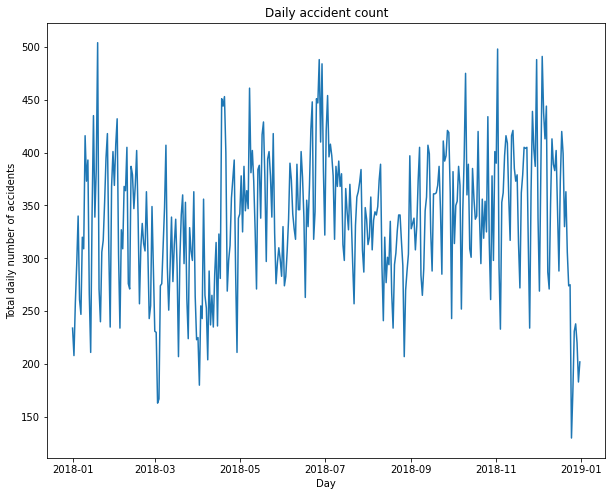

In [161]:
acc_daily = df.groupby("day").sum("Count")
acc_daily.drop(columns=["High_Winds","day_n","month_n",'hour'],inplace=True)

plt.figure(figsize=(10,8))
plt.title("Daily accident count")
plt.plot(acc_daily)
plt.xlabel("Day")
plt.ylabel("Total daily number of accidents")
plt.show()

### **2) Train / Test Split**

In [162]:
train_set,test_set = train_test_split(df,test_size=0.2, random_state=7, shuffle=False)
print(f"{train_set.shape[0]} train and {test_set.shape[0]} test instances")

6832 train and 1708 test instances


### **3) EDA & Descriptive Statistics**

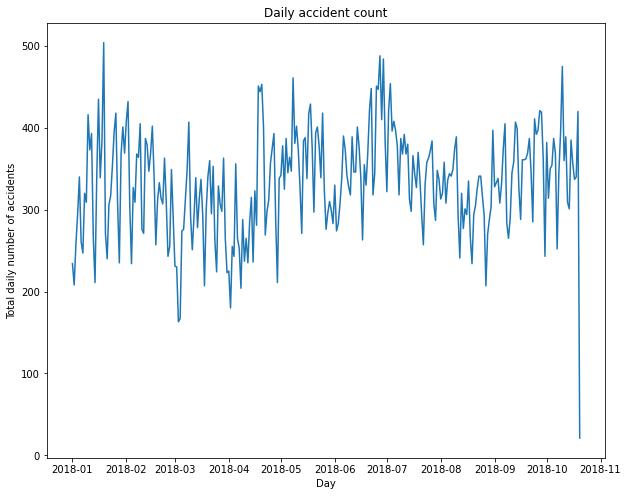

In [163]:
acc_daily_train = train_set.groupby("day").sum("Count")
acc_daily_train.drop(columns=["High_Winds","day_n","month_n",'hour'],inplace=True)
#acc_daily_train
plt.figure(figsize=(10,8))
plt.title("Daily accident count")
plt.plot(acc_daily_train)
plt.xlabel("Day")
plt.ylabel("Total daily number of accidents")
plt.show()

In [164]:
print(f"As the graph shows the daily accident numbers swing between:", acc_daily_train["Count"].max(),"as maximum and",acc_daily_train["Count"].min(),"minimun." )

As the graph shows the daily accident numbers swing between: 504 as maximum and 21 minimun.


In [165]:
train_set.columns

Index(['datetime', 'Count', 'Day_of_Week', 'Precipitation', 'High_Winds',
       'Road_Surface_Conditions', 'Light_Conditions', 'Urban_or_Rural_Area',
       'day', 'day_n', 'hour', 'month', 'month_n', 'Weekend', 'Season'],
      dtype='object')

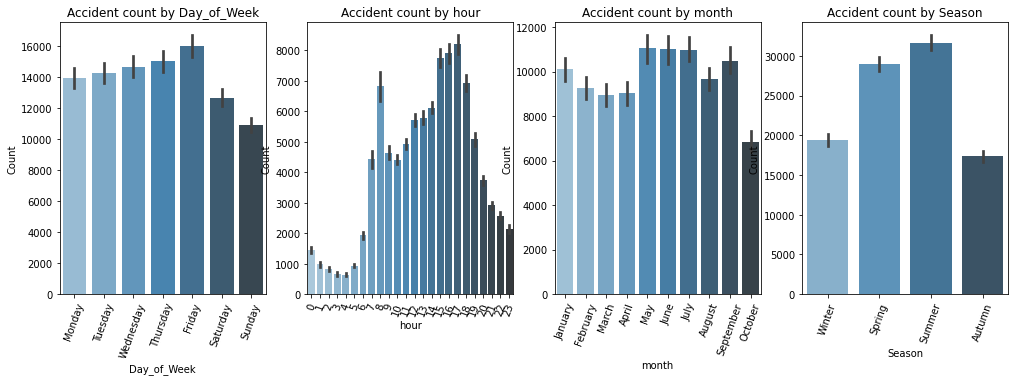

In [166]:
c = 1

fig = plt.figure(figsize=(17,5))

for i in df[["Day_of_Week",'hour','month','Season']]:
    plt.subplot(1, 4, c)
    plt.title(f'Accident count by {i}')
    plt.xlabel(i)
    plt.xticks(rotation=70)
    sns.barplot(x=i,y="Count",data=train_set,estimator=sum, palette="Blues_d")
    c = c + 1

plt.show()

Concerning the date and time of the data one can recognize that accidents are evenly distributed between the weekdays and only *sligthly* peak on Fridays and have a *slight* bottom on Sundays. 
Regarding the hours there is a more clear distribution towards the rush hour hours from 16:00 to 18:00 as well as in the mornings between 7:00 and 9:00. 

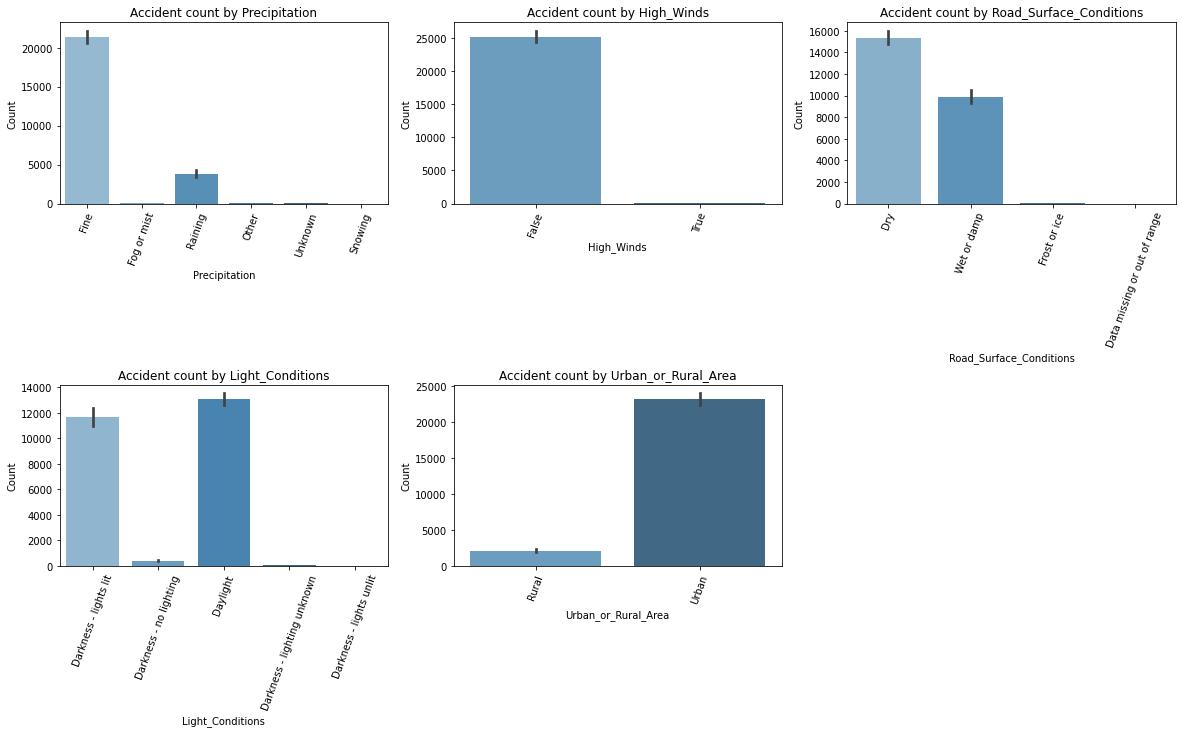

In [167]:
c = 1

fig = plt.figure(figsize=(20,10))

for i in df[['Precipitation',
       'High_Winds', 'Road_Surface_Conditions', 'Light_Conditions',
       'Urban_or_Rural_Area']]:
    plt.subplot(2, 3, c)
    plt.subplots_adjust(hspace=1)
    plt.title(f'Accident count by {i}')
    plt.xlabel(i)
    plt.xticks(rotation=70)
    sns.barplot(x=i,y="Count",data=test_set,estimator=sum, palette="Blues_d")
    c = c + 1

plt.show()

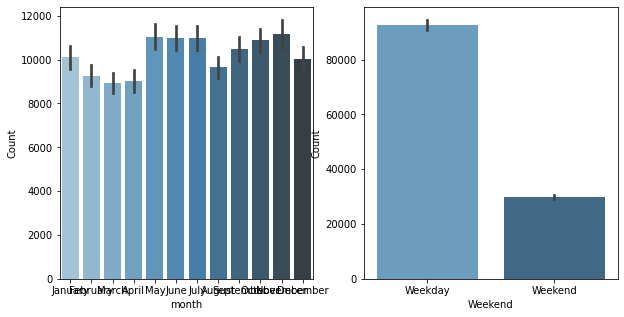

In [168]:
fig,axes = plt.subplots(1,2,figsize=(10,5))
sns.barplot(ax= axes[0], data=df, x='month', y='Count',estimator=sum,palette="Blues_d")
sns.barplot(ax=axes[1], data=df, x='Weekend', y='Count',estimator=sum,palette="Blues_d")
plt.show()

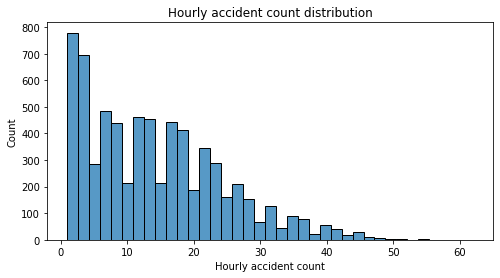

In [169]:
plt.figure(figsize=(8,4))
sns.histplot(data=train_set, x="Count")
plt.title("Hourly accident count distribution")
plt.xlabel("Hourly accident count")
plt.show()

### 4) **Data Preprocessing**

In [170]:
train_set.isna().sum()

datetime                   0
Count                      0
Day_of_Week                0
Precipitation              0
High_Winds                 0
Road_Surface_Conditions    0
Light_Conditions           0
Urban_or_Rural_Area        0
day                        0
day_n                      0
hour                       0
month                      0
month_n                    0
Weekend                    0
Season                     0
dtype: int64

In [171]:

for i in train_set[['Day_of_Week', 'Precipitation', 'High_Winds',
       'Road_Surface_Conditions', 'Light_Conditions', 'Urban_or_Rural_Area']]:
    x = train_set[i].value_counts()
    print("Column name is: ",i,"and its unique value counts are:",x)

Column name is:  Day_of_Week and its unique value counts are: Saturday     985
Friday       982
Sunday       981
Monday       979
Wednesday    972
Thursday     971
Tuesday      962
Name: Day_of_Week, dtype: int64
Column name is:  Precipitation and its unique value counts are: Fine                            6094
Raining                          528
Snowing                          116
Other                             41
Unknown                           37
Fog or mist                       15
Data missing or out of range       1
Name: Precipitation, dtype: int64
Column name is:  High_Winds and its unique value counts are: False    6775
True       57
Name: High_Winds, dtype: int64
Column name is:  Road_Surface_Conditions and its unique value counts are: Dry                             5346
Wet or damp                     1308
Snow                             115
Frost or ice                      49
Data missing or out of range       9
Flood over 3cm. deep               5
Name: Road_Sur

In [172]:
train_set.loc[train_set["Road_Surface_Conditions"].str.contains("Flood"), "Road_Surface_Conditions"] = "Wet or damp"

In [173]:
indexNames = train_set[(train_set['Precipitation'] == "Unknown") | (train_set['Precipitation'] == "Data missing or out of range") | (train_set["Road_Surface_Conditions"] == "Data missing or out of range")].index
train_set.drop(indexNames , inplace=True)


In [174]:
for i in train_set[['Day_of_Week', 'Precipitation', 'High_Winds',
       'Road_Surface_Conditions', 'Light_Conditions', 'Urban_or_Rural_Area']]:
    x = train_set[i].value_counts()
    print("Column name is: ",i,"and its unique value counts are:",x)

Column name is:  Day_of_Week and its unique value counts are: Saturday     981
Friday       977
Monday       975
Sunday       973
Thursday     967
Wednesday    967
Tuesday      952
Name: Day_of_Week, dtype: int64
Column name is:  Precipitation and its unique value counts are: Fine           6092
Raining         528
Snowing         116
Other            41
Fog or mist      15
Name: Precipitation, dtype: int64
Column name is:  High_Winds and its unique value counts are: False    6735
True       57
Name: High_Winds, dtype: int64
Column name is:  Road_Surface_Conditions and its unique value counts are: Dry             5329
Wet or damp     1300
Snow             115
Frost or ice      48
Name: Road_Surface_Conditions, dtype: int64
Column name is:  Light_Conditions and its unique value counts are: Daylight                       4107
Darkness - lights lit          2202
Darkness - no lighting          386
Darkness - lighting unknown      75
Darkness - lights unlit          22
Name: Light_Conditio

Comparing the value counts of each feature, "Data that was out of range", "Unknown" was dropped from the dataset. Furthermore, 5 lines of data with the value "Flood over 3cm was attached to "wet or dump surface conditions".

**4) Label Encoding and dummy variables**


In [175]:
cat_vals = ['Precipitation', 'High_Winds','Road_Surface_Conditions', 'Light_Conditions', 'Urban_or_Rural_Area', 'Weekend','Season']
vals = train_set[cat_vals]

In [176]:
categ = ['Precipitation','High_Winds',
       'Road_Surface_Conditions', 'Light_Conditions', 'Urban_or_Rural_Area','Weekend', 'Season']
lenc = LabelEncoder()

In [177]:
train_set_lenc = train_set

In [178]:
train_set_lenc[categ] = train_set_lenc[categ].apply(lenc.fit_transform)

In [179]:
train_set_lenc.columns

Index(['datetime', 'Count', 'Day_of_Week', 'Precipitation', 'High_Winds',
       'Road_Surface_Conditions', 'Light_Conditions', 'Urban_or_Rural_Area',
       'day', 'day_n', 'hour', 'month', 'month_n', 'Weekend', 'Season'],
      dtype='object')

In [180]:
train_set_lenc = train_set_lenc[['datetime', 'Count', 'Precipitation', 'High_Winds',
       'Road_Surface_Conditions', 'Light_Conditions', 'Urban_or_Rural_Area', 'day_n', 'hour', 'month_n', 'Weekend', 'Season']]
train_set_lenc.head()

,datetime,Count,Precipitation,High_Winds,Road_Surface_Conditions,Light_Conditions,Urban_or_Rural_Area,day_n,hour,month_n,Weekend,Season
0,2018-01-01 00:00:00,18,0,0,0,1,1,1,0,1,0,3
1,2018-01-01 01:00:00,9,0,0,3,1,1,1,1,1,0,3
2,2018-01-01 02:00:00,14,0,0,3,1,1,1,2,1,0,3
3,2018-01-01 03:00:00,10,0,0,3,1,1,1,3,1,0,3
4,2018-01-01 04:00:00,8,0,0,0,1,1,1,4,1,0,3


In [206]:
test_set_lenc = test_set
test_set_lenc[categ] = test_set_lenc[categ].apply(lenc.fit_transform)
test_set_lenc = test_set_lenc[['datetime', 'Count', 'Precipitation', 'High_Winds',
       'Road_Surface_Conditions', 'Light_Conditions', 'Urban_or_Rural_Area', 'day_n', 'hour', 'month_n', 'Weekend', 'Season']]
test_set_lenc.head()

,datetime,Count,Precipitation,High_Winds,Road_Surface_Conditions,Light_Conditions,Urban_or_Rural_Area,day_n,hour,month_n,Weekend,Season
6832,2018-10-20 05:00:00,2,0,0,1,1,0,20,5,10,1,0
6833,2018-10-20 06:00:00,3,1,0,1,3,1,20,6,10,1,0
6834,2018-10-20 07:00:00,7,0,0,1,4,0,20,7,10,1,0
6835,2018-10-20 08:00:00,3,0,0,1,4,0,20,8,10,1,0
6836,2018-10-20 09:00:00,12,0,0,1,4,1,20,9,10,1,0


### **5) Feature selection**

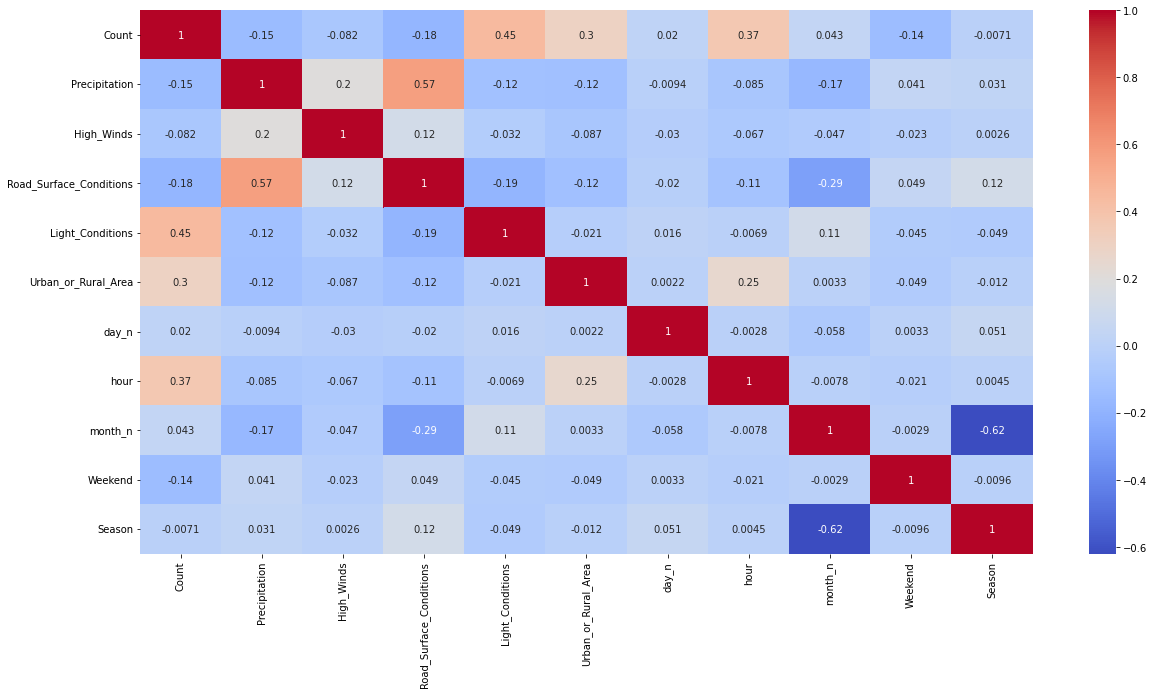

In [181]:
corr_mat_lenc = train_set_lenc.corr()
plt.figure(figsize=(20,10))
sns.heatmap(corr_mat_lenc, annot=True, cmap="coolwarm")
plt.show()

The correlation heatmap shows that there seems to be no multicollinearity between the features, only month and season seem to have multicollinearity as these values are close to -1. Moreover, considering the correlation between "Count" and the features, "High wind", "Season", "day_n" and "month_n" will not be considered as features of the model.

### **5) Baseline Model**

In [182]:
median_accident_count = train_set_lenc["Count"].median()
print(f"There are:", median_accident_count,"accidents per hour.")

There are: 13.0 accidents per hour.


In [183]:
yhat =  np.full((train_set_lenc.shape[0],1), median_accident_count)

In [184]:
baseline_mse = mean_squared_error(train_set_lenc["Count"],yhat)
print(f"The baseline MSE is:",baseline_mse)

baseline_rmse = np.sqrt(baseline_mse)
print(f"The basline RMSE is:",baseline_rmse)

The baseline MSE is: 108.2946113074205
The basline RMSE is: 10.406469685124755


The RMSE of 10.4 indicates the amount by which the baseline gets hourly accident count wrong which is quite a big amount comparing to the mean of 13 accidents per hour. This suggests this is a difficult problem to solve.

### **6) ARIMA Model**

In [185]:
train_set_lenc.head()

,datetime,Count,Precipitation,High_Winds,Road_Surface_Conditions,Light_Conditions,Urban_or_Rural_Area,day_n,hour,month_n,Weekend,Season
0,2018-01-01 00:00:00,18,0,0,0,1,1,1,0,1,0,3
1,2018-01-01 01:00:00,9,0,0,3,1,1,1,1,1,0,3
2,2018-01-01 02:00:00,14,0,0,3,1,1,1,2,1,0,3
3,2018-01-01 03:00:00,10,0,0,3,1,1,1,3,1,0,3
4,2018-01-01 04:00:00,8,0,0,0,1,1,1,4,1,0,3


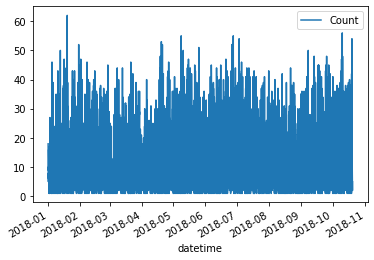

In [186]:
train_set_lenc_ts = train_set_lenc[["datetime","Count"]]
train_set_lenc_ts.set_index("datetime",inplace=True)
train_set_lenc_ts.plot()

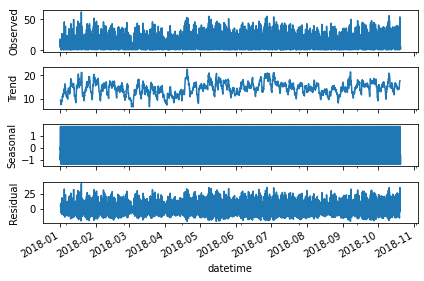

In [187]:
decomposition1 = seasonal_decompose(train_set[["day","Count"]].groupby("day").sum("Count"), freq=12)
decomposition.plot()
plt.show()

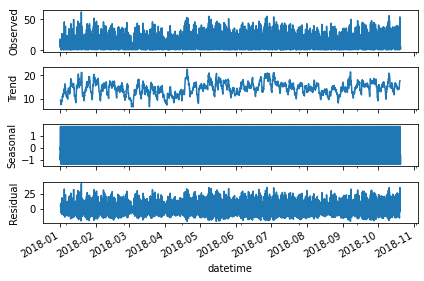

In [188]:
decomposition = seasonal_decompose(train_set_lenc_ts["Count"], freq=24)
decomposition.plot()
plt.show()

Seasonal decomposition of the daily as well of the hourly data shows that there is no seasonality in the accident count.


**Augmented Dickey Fuller Test**

In [189]:
adf_test_result = adfuller(train_set_lenc_ts["Count"].values)
print("ADF Statistic: %f" % adf_test_result[0]) 
print("p-value: %f" % adf_test_result[1])
print("Critical Values:")
for key, value in adf_test_result[4].items():
  print('\t%s: %.3f' % (key,value))
if adf_test_result[0] < adf_test_result[4]["5%"]:
  print("Reject H0 - Time Series is Stationary")
else:
  print("Accept H0 - Time series is Non-Stationary")

ADF Statistic: -10.108665
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Reject H0 - Time Series is Stationary


The Augmented Dickey Fuller Test indicates that the data is already stationary and does not need to be differenced.

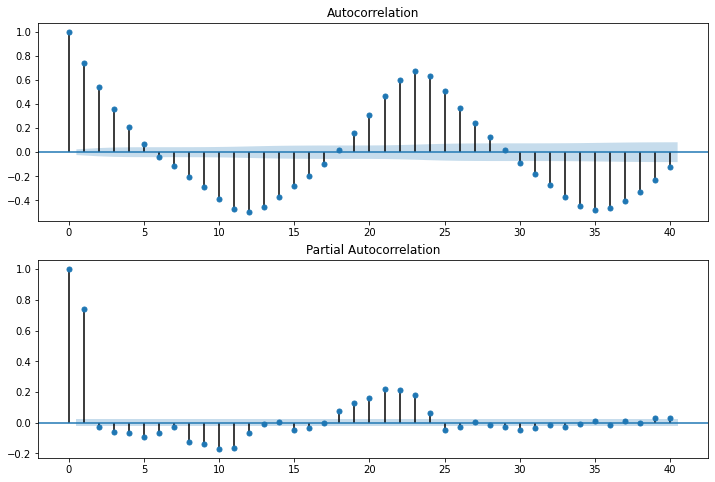

In [190]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_set_lenc_ts["Count"],lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_set_lenc_ts["Count"],lags=40, ax=ax2)
plt.show()

### **7) Random Forest Regression Model / Decision tree Regressor**


In [252]:
X_train = train_set_lenc[["Precipitation","Road_Surface_Conditions", "Light_Conditions","Urban_or_Rural_Area","hour","Weekend"]]
X_test =  test_set_lenc[["Precipitation","Road_Surface_Conditions", "Light_Conditions","Urban_or_Rural_Area","hour","Weekend"]]

In [253]:
y_train = train_set_lenc["Count"]
y_test= test_set_lenc["Count"]

In [228]:
rfr = RandomForestRegressor()

In [229]:
rfr.fit(X_train, y_train)

RandomForestRegressor()

In [260]:
y_pred = rfr.predict(X_test)
y_pred

array([ 3.51073016,  4.2595933 ,  4.89661108, ..., 10.19844941,
        8.82186766,  7.73161265])

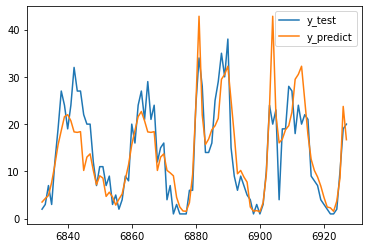

In [273]:
y_test["y_predict"] = y_pred
y_test.rename(columns={"Count":"y_test"},inplace=True)
df_tmp = y_test[:96]
df_tmp.plot()

In [251]:
df_tmp = y_pred.merge(y_test, left_on=None, right_on=None, left_index=True, right_index=True)
df_tmp

,0,Count


In [234]:
rfr_mse = mean_squared_error(y_test, y_pred)
rfr_mse

40.983353282473615

In [236]:
rfr_rmse = np.sqrt(rfr_mse)
rfr_rmse

6.401824215211912

### **8) Decision Tree Regressor Model**


### **9) Discussion**

### **10) Future outlook**

In [191]:
word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print(f"Word count: {word_count}")

NameError: ignored